# Notebook 6: Addis Ababa Industrial Production Model

## README

### Overview

This notebook focuses on developing  machine learning models to explain monthly export patterns in Addis Ababa, using spatial, environmental, and infrastructural variables - particularly nitrogen dioxide (NO₂) concentrations - as proxies. It explores whether air pollution data can effectively reflect urban economic dynamics in data-scarce contexts, offering new approaches for economic monitoring.

### Objective

1. Evaluate machine learning model techniques to explain sub-city economic activity in Addis Ababa, using export as a proxy.

2. Quantify the relationship between NO₂ concentration and economic throughput, validating NO₂ as a proxy of economic activity.

3. Provide interpretable metrics such as feature importance and local elasticities based on SHAP values to support policy decisions.

4. Save the trained best XGBoost model in *JSON* format for easier deployment and reproducibility.

### Modelling Results

#### Best Model and NO₂ Significance

We first built an XGBoost model using NO₂ along with other economic proxies (e.g., Nighttime Light and land use features), and identified the best-performing hyperparameter configuration. Using this optimized setup, we then re-trained the model excluding NO₂ to assess its marginal contribution, results are summarized in the table below.

| Model Type | Including NO₂ |     RMSE      |   R²    | Best Parameters |
|------------|----------------|---------------|---------|-----------------|
| XGBoost    | Yes            | 3.16e+08      | 0.468   | 'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.7 |
| XGBoost    | No             | 3.84e+08      | 0.213   | 'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.1, 'colsample_bytree': 0.7 |

As shown above, **removing NO₂ leads to a substantial decline in model performance**: RMSE increases from 315.7 million to 383.8 million, while R² drops from 0.468 to 0.213. **This clearly highlights NO₂’s role in enhancing model accuracy and supports its value as a complementary proxy for economic activity.**

#### Feature Contribution

Based on the best XGBoost model, the calculated SHAP values are visualized in the figure below.

<p align="center">
  <img src="../data/demo-data/Addis Ababa - SHAP Feature Impact - XGBoost.png" alt="SHAP Feature Impact" width="1000"/>
</p>

<p align="center">
  <em>SHAP Feature Impact XGB Model Results for Addis Ababa</em>
</p>

`NO₂_Level` (nitrogen dioxide concentration) is the most important feature in the model, ranking first in the chart. Its SHAP values are distributed in both positive and negative directions, indicating a significant and bidirectional impact on predictions. 
This aligns with the fact that NO₂ mainly comes from industrial and traffic emissions, and higher concentrations reflect more active economic activity. In comparison, Nighttime_Light and POI_Count, as traditional proxies for economic activity, have some explanatory power but their influence is slightly weaker than NO₂. Road_Length and Population are also important, with the impact of Road_Length close to that of NO₂. Different land use types (industrial, commercial, residential) have relatively small effects, suggesting that single land use types have limited predictive power for economic activity and need to be combined with other features.

#### Approximate Elasticity

Based on the best model found in XGBoost, the approximate elasticity of each feature was estimated using SHAP values, which capture the marginal contribution of each variable. The table below summarizes the median elasticity values across all samples: 

| Feature               | Median Elasticity |
|-----------------------|-------------------|
| poi_count             | 3.77e+07          |
| road_len              | 0.186             |
| no2_mean              | 0.154             |
| pop_sum_m             | 0.136             |
| lu_residential_area   | 0.00507           |
| lu_industrial_area    | 0.000633          |
| lu_commercial_area    | 0.00000           |
| NTL_mean              | -0.0321           |


### Conclusion

The results of the XGBoost model applied to Addis Ababa demonstrate that nitrogen dioxide (NO₂), as a spatial-environmental feature, plays a significant role in predicting economic activity intensity in this urban context. SHAP analysis indicates that `NO₂_Level` ranks among the most influential features, comparable in impact to traditional infrastructure indicators such as `Road_Length`. **Its inclusion notably improves model performance by reducing RMSE and increasing R², underscoring NO₂’s critical role in capturing spatial-economic patterns within Addis Ababa.**

While conventional proxies like `Nighttime_Light` and `POI_Count` continue to exhibit explanatory power, their marginal contributions are relatively limited in this setting. In contrast, NO₂ acts as a strong complementary variable that enhances predictive accuracy beyond these traditional indicators. **This finding suggests that NO₂ can be effectively used not only as an input feature within predictive models but also as a standalone spatial proxy for economic activity intensity in similar urban environments.**

Given its advantages - global coverage, frequent updates, and low acquisition costs - satellite-derived NO₂ data holds particular promise for application in low- and middle-income countries, especially in urban areas where economic data may be sparse, outdated, or unreliable. This includes regions characterized by informal economies or affected by conflict, where conventional economic statistics are often insufficient. Thus, NO₂ offers a valuable and practical tool for monitoring and analysing economic activity in data-scarce contexts, as exemplified by the Addis Ababa case study.


## 0 Init: Prepare Packages and Configuration

Get current file/repo/data path in local to make sure the following cells run properly.

In [1]:
import sys
from pathlib import Path
SRC_PATH = Path().resolve().parent / "src"
sys.path.append(str(SRC_PATH))


from config import *
FILE_PATH = DATA_PATH / 'temp' 

## 1 Data Import and Feature Engineering

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from analysis import* 

# Load and preprocess data ===
addis_df = pd.read_csv(FILE_PATH / "addis-industrial-model.csv")

addis_df['ind_no2'] = addis_df['lu_industrial_area'] * addis_df['no2_mean']
addis_df['com_no2'] = addis_df['lu_commercial_area'] * addis_df['no2_mean']


In [20]:
# rename mapping
rename_dict = {
    "no2_mean": "NO2_Level",
    "NTL_mean": "Nighttime_Light",
    "poi_count": "POI_Count",
    "pop_sum_m": "Population",
    "road_len": "Road_Length",
    "lu_industrial_area": "Industrial_Area",
    "lu_commercial_area": "Commercial_Area",
    "lu_residential_area": "Residential_Area",
    "export-raw": "Export_Value"
}

addis_df = addis_df.rename(columns=rename_dict)

# select features
features = [
    "NO2_Level",
    "Nighttime_Light",
    "POI_Count",
    "Population",
    "Road_Length",
    "Industrial_Area", 
    "Commercial_Area", 
    "Residential_Area",
]
target = ["Export_Value"]

X = addis_df[features].values
y = addis_df[target].values

# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X = MinMaxScaler((0, 100))
scaler_y = MinMaxScaler((0, 100))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

## 2 XGBoost Model 

NO₂ is used as a key contributor to export value, serving as an indicator of economic activity.

### 2.1 Fine-tune the Best Parameter Combination

In [21]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler

Best params: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.7}

In [6]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 100     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.7}
# Final RMSE on test set: 315700697.79980415
# R squared on test set: 0.46792489574671214

Progress: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Best RMSE: 315700701.19310397
Best params: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.7}
Final RMSE on test set: 315700697.79980415
R squared on test set: 0.46792489574671214


In [ ]:
# =================BEST MODEL====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.7
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred = best_model_xgb.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Final RMSE on test set: 315700697.79980415
# R squared on test set: 0.46792489574671214

best_model_xgb.save_model("addis-ababa-economic-model.json")

# # Load the Model
# loaded_model = xgb.XGBRegressor()
# loaded_model.load_model("addis-ababa-economic-model.json")

Final RMSE on test set: 315700697.79980415
R squared on test set: 0.46792489574671214


### 2.2 Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

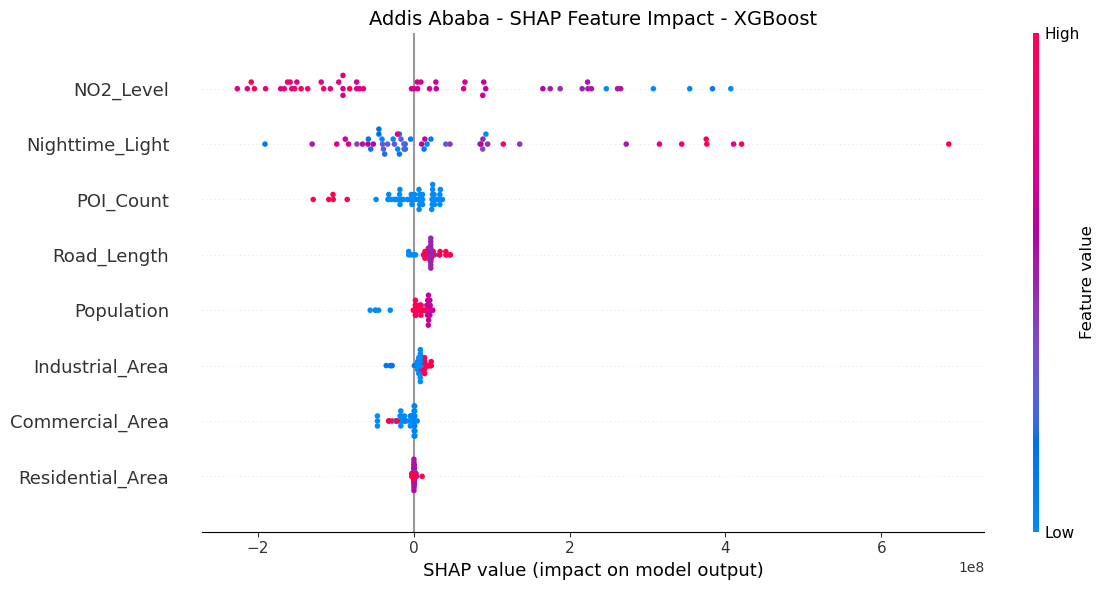

In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    output_path = DEMO_PATH,
    max_display=15,
    clip_range=(-10e8, 10e8),
    plot_title="Addis Ababa - SHAP Feature Impact - XGBoost"
)

### 2.3 Approximate Feature Elasticity

In [24]:
compute_elasticities_shap_xgb(model=best_model_xgb, shap_exp=shap_exp,)

,feature,median_elasticity,p10,p90
2,POI_Count,3.768086e+07,-5.513953e+08,7.570727e+07
4,Road_Length,1.856619e-01,-5.989258e-03,8.208072e-01
0,NO2_Level,1.536438e-01,-1.785789e+01,2.075907e+00
3,Population,1.361990e-01,-8.802026e-02,7.157366e-01
7,Residential_Area,5.069898e-03,-1.351771e-02,1.643720e-02
5,Industrial_Area,6.331545e-04,-9.880788e-03,1.741217e-01
6,Commercial_Area,0.000000e+00,-4.544515e-01,6.309496e-03
1,Nighttime_Light,-3.210603e-02,-1.569982e+00,2.178604e+00


## 3 XGBoost Model Without NO₂

In this chapter, we excluded NO₂ and rebuilt the model using other proxies such as Nighttime Light and land use features. We then compared the results with the previous best model that included NO₂, thereby justifying the assumption that NO₂ values can supplement other proxies like Nighttime Lights.

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler

In [10]:
# select features
features = [
    # "no2_mean", # excluding no2_mean
    "NTL_mean",
    "poi_count",
    "pop_sum_m",
    # "ind_no2",
    # "com_no2",
    "road_len",
    'lu_industrial_area', 
    'lu_commercial_area', 
    'lu_residential_area',

]
target = ["export-raw"]

X = addis_df[features].values
y = addis_df[target].values
# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

Best params: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.1, 'colsample_bytree': 0.7}

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 100     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.1, 'colsample_bytree': 0.7}
# Final RMSE on test set: 383842822.1701253
# R squared on test set: 0.21344571266019496

Progress: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]

Best params: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 6, 'eta': 0.1, 'colsample_bytree': 0.7}
Final RMSE on test set: 383842822.1701253
R squared on test set: 0.21344571266019496
